# Barcode Extraction Pipeline

In [1]:
# import the necessary packages
import os
import cv2
import numpy as np
from imutils import contours
import matplotlib.pyplot as plt
from skimage.feature import hog # HOG Feature Extractor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import  train_test_split
% matplotlib inline

### Input image

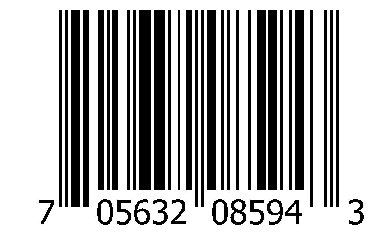

In [2]:
img = cv2.imread('/path/to/image.jpg', cv2.IMREAD_GRAYSCALE)
plt.axis('off')
plt.imshow(img, cmap='gray')
plt.show()

We first need to remove the vertical bars present in the image and then using the findContours function we will extract the digits present in the image.

In [3]:
def image_preprocessing(image):
    
    # input - grayscale image
    # removes vertical lines present in the image
    
    vertical = cv2.bitwise_not(image)
    # Specify size on vertical axis
    rows = vertical.shape[0]
    verticalsize = rows // 5
    # Create structure element for extracting vertical lines through morphology operations
    verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (1, verticalsize))
    # Apply morphology operations
    vertical = cv2.erode(vertical, verticalStructure)
    vertical = cv2.dilate(vertical, verticalStructure)
    
    final = cv2.bitwise_or(image, vertical)
    thresh = cv2.threshold(final, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    return thresh    

### Image after processing

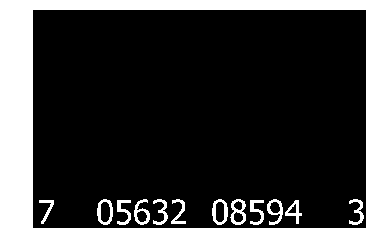

In [4]:
thresh_img = image_preprocessing(img)
plt.axis('off')
plt.imshow(thresh_img, cmap='gray')
plt.show()

In [5]:
def extract_digit(image, contour):
    
    # input - thresholded image 
    #       - contours present in the image
    # returns a cropped image of the digit 
        
    mask = np.zeros(image.shape,dtype="uint8")
    (x,y,w,h) = cv2.boundingRect(contour)
    hull = cv2.convexHull(contour)
    cv2.drawContours(mask,[hull], -1,255,-1)
    mask = cv2.bitwise_and(image,image,mask=mask)
    digit = mask[y:y+h,x:x+w]
    digit = cv2.resize(digit,(40,64))
    
    return digit        

### Extracted Digits

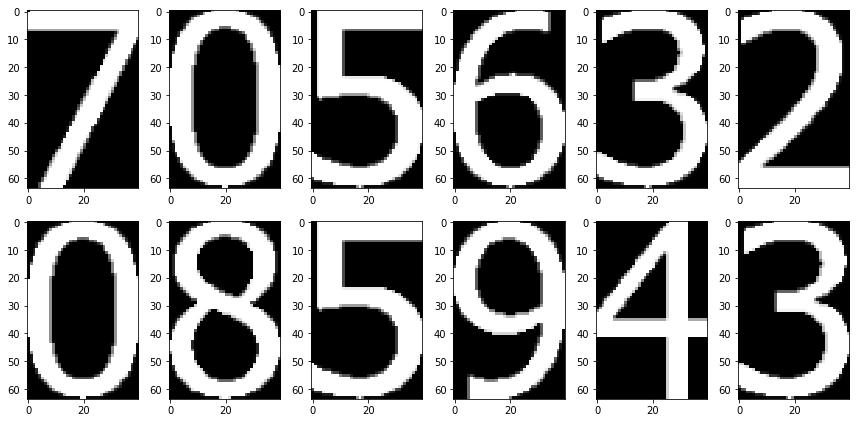

In [6]:
(cnts,_) = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
(cnts, _) = contours.sort_contours(cnts, method="left-to-right")
avgCntArea = np.mean([cv2.contourArea(k) for k in cnts])

digit = []
for (i,c) in enumerate(cnts):
    if cv2.contourArea(c)<avgCntArea/10:
        continue

    digit.append(extract_digit(thresh_img, c))

fig, axes = plt.subplots(2, 6, figsize=(12, 6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    dig= digit[i]
    ax.imshow(dig, cmap='gray')
plt.tight_layout()
plt.show()

## Create the training set

Save the digits present in the barcodes and sort them manually to form the training set.

In [ ]:
train_dir = '/path/to/directory/' # directory containing images of barcode
for filename in os.listdir(train_dir):
    
    image = cv2.imread(os.path.join(train_dir, filename), cv2.IMREAD_GRAYSCALE)
    thresh = image_pre_processing(image)
    
    (cnts,_) = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    (cnts, _) = contours.sort_contours(cnts, method="left-to-right")
    avgCntArea = np.mean([cv2.contourArea(k) for k in cnts])

    for (i,c) in enumerate(cnts):
        if cv2.contourArea(c)<avgCntArea/10:
            continue
            
        digit = extract_digit(thresh, c)
        save_img_dir = '/path/to/directory/image.jpg' #directory to save the digits
        cv2.imwrite(save_img_dir, digit)

## Training the model

A simple KNN Classifier with n_neighbors=1 gives good accuracy on the training as well as validation set.

In [7]:
features_list = []
features_label = []

for digit in range(0,10):
    label = digit
    train_dir = '/path/to/training/images/' + str(label) + '/'
    for filename in os.listdir(train_dir):
        image = cv2.imread(os.path.join(train_dir, filename), cv2.IMREAD_GRAYSCALE)
        # Using Histogram of Oriented Gradients(HOG) feature extractor
        feat = hog(image, orientations=7, pixels_per_cell=(6,6), cells_per_block=(4,4),
                 transform_sqrt=True, block_norm="L2")
        features_list.append(feat)
        features_label.append(label)
        
#convert features array into a numpy array
features  = np.array(features_list, 'float64')

# split the dataset 
#X_train, X_test, y_train, y_test = train_test_split(features, features_label)

# train using KNN 
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(features, features_label)

#model_score_train = knn.score(X_train, y_train)
#model_score_test = knn.score(X_test, y_test)

# Printing the scores
#print('Train accuracy : ',model_score_train)
#print('Test accuracy : ', model_score_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

## Predictions on Test Set

In [8]:
def extract_barcode(test_image):
    
    # input - test image in grayscale
    # returns barcode present in the image
    
    barcode=[]
    thresh = image_preprocessing(test_image)
    
    (cnts,_) = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    (cnts, _) = contours.sort_contours(cnts, method="left-to-right")
    avgCntArea = np.mean([cv2.contourArea(k) for k in cnts])

    for (i,c) in enumerate(cnts):
        if cv2.contourArea(c)<avgCntArea/10:
            continue
            
        digit = extract_digit(thresh, c)
        feat = hog(digit, orientations=7, pixels_per_cell=(6,6), cells_per_block=(4,4),
                   transform_sqrt=True, block_norm="L2")
        features  = np.array(feat, 'float64')
        
        predict = knn.predict(features.reshape(1,-1))[0]
        barcode.append(predict)
    
    barcode = int(''.join(map(str, barcode)))
    
    return barcode    

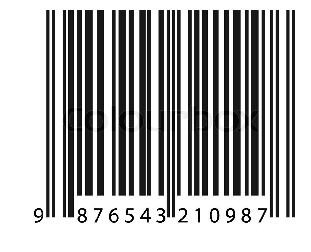

Barcode: 9876543210987


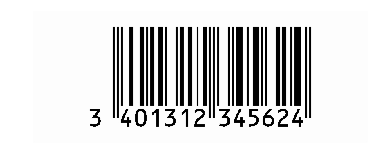

Barcode: 3401312345624


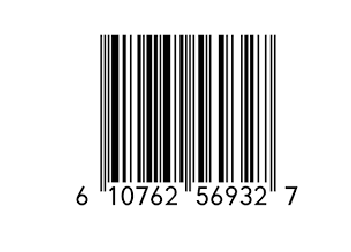

Barcode: 610762569327


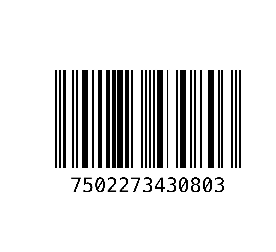

Barcode: 7502273430803


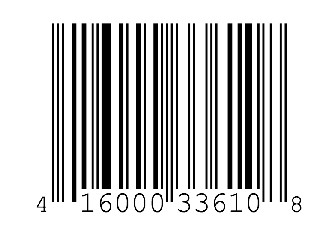

Barcode: 416000336108


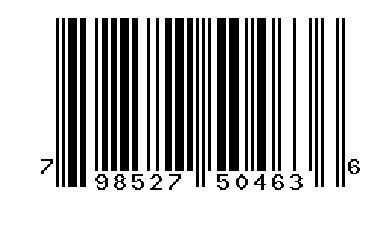

Barcode: 798527504636


In [9]:
test_dir = '/path/to/test/images'# directory containing test images

for filename in os.listdir(test_dir):
    image = cv2.imread(os.path.join(test_dir, filename), cv2.IMREAD_GRAYSCALE)
    plt.axis('off')
    plt.imshow(image, cmap='gray')
    plt.show()
      
    print('Barcode:', extract_barcode(image))